# Customer Churn Prediction – Model Training Notebook

This notebook covers:

- Data Cleaning
- Feature Engineering
- Model Training (Logistic, RF, XGBoost)
- Evaluation (Accuracy, AUC, ROC, PR Curve)
- Saving Final Model and Scaler

Dataset: Telco Customer Churn Dataset from IBM.


In [12]:
import pandas as pd

# Load raw dataset
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Original shape:", df.shape)
df.head()


Original shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
# Convert 'TotalCharges' to numeric and drop missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Drop customerID (not needed for modeling)
df.drop('customerID', axis=1, inplace=True)

# Save cleaned data
df.to_csv('cleaned_telco_churn.csv', index=False)
print("Cleaned and saved!")


Cleaned and saved!


In [14]:

df = pd.read_csv('/content/cleaned_telco_churn.csv')

# Count how many services customer has
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies']
df['ServiceCount'] = df[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

# Create TenureGroup
def tenure_group(tenure):
    if tenure <= 12:
        return '0–1 year'
    elif tenure <= 24:
        return '1–2 years'
    elif tenure <= 48:
        return '2–4 years'
    elif tenure <= 60:
        return '4–5 years'
    else:
        return '5+ years'
df['TenureGroup'] = df['tenure'].apply(tenure_group)

# Monthly charges bucket
def charges_bucket(charge):
    if charge < 35:
        return 'Low'
    elif charge < 70:
        return 'Medium'
    else:
        return 'High'
df['MonthlyChargesBucket'] = df['MonthlyCharges'].apply(charges_bucket)

# Convert Yes/No to 1/0
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})
df.replace({'Yes': 1, 'No': 0}, inplace=True)

# One-hot encode categorical features
df = pd.get_dummies(df, drop_first=True)

# Save preprocessed data
df.to_csv('final_preprocessed_churn.csv', index=False)
print("Feature engineering complete. Final shape:", df.shape)


/tmp/ipython-input-4285231937.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Yes': 1, 'No': 0}, inplace=True)


Feature engineering complete. Final shape: (7032, 38)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Load final data
df = pd.read_csv('final_preprocessed_churn.csv')
X = df.drop('Churn', axis=1)
y = df['Churn']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [16]:
# Logistic Regression
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)
print("LogReg Accuracy:", accuracy_score(y_test, logreg.predict(X_test)))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("RF Accuracy:", accuracy_score(y_test, rf.predict(X_test)))


LogReg Accuracy: 0.7896233120113717
RF Accuracy: 0.7846481876332623


In [17]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb.predict(X_test)))


XGBoost Accuracy: 0.7661691542288557


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

grid = GridSearchCV(XGBClassifier(eval_metric='logloss'),
                    param_grid,
                    scoring='roc_auc',
                    cv=3,
                    verbose=1)

grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_


Fitting 3 folds for each of 8 candidates, totalling 24 fits


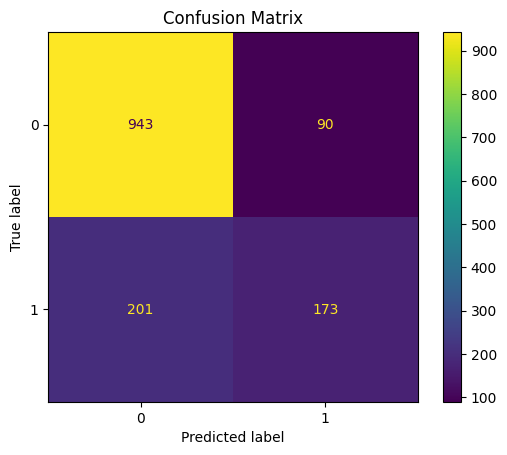

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.87      1033
           1       0.66      0.46      0.54       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



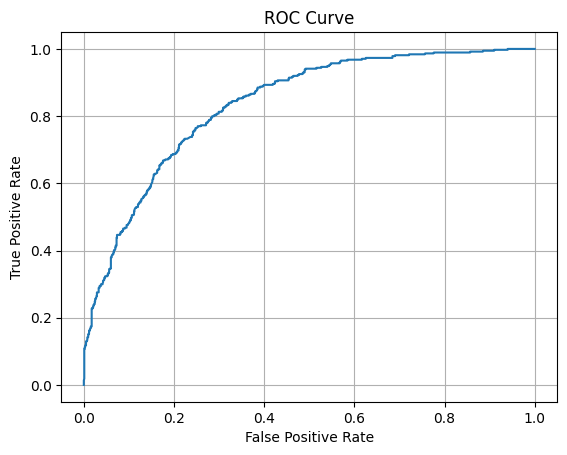

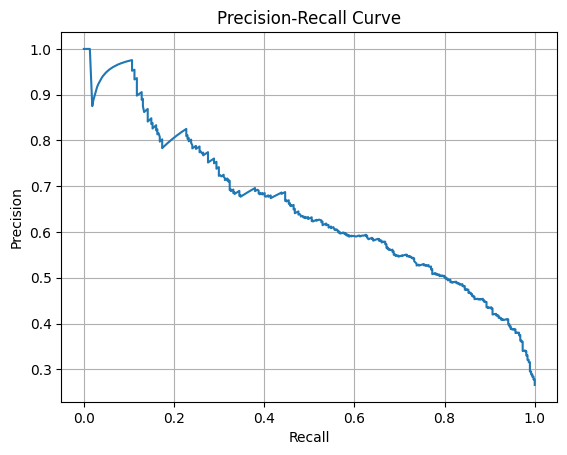

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# Confusion matrix
y_pred = best_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_xgb.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, best_xgb.predict_proba(X_test)[:,1])
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


In [20]:
import joblib

# Save the final best model
joblib.dump(best_xgb, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ Model and scaler saved!")


✅ Model and scaler saved!
